In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/nmuller/projects/ganglion_density_sampling')
from GDS import GanglionDensitySampling
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_utils.pytorch_utils import ToOpponentChannel, ToRetinalGanglionCellSampling, convert_from_cv2_to_image, convert_from_image_to_cv2

In [2]:
# image = Image.open('/home/nmuller/projects/data/oads/oads_arw/tiff/0000018494729a82.tiff')
# image = '/home/nmuller/projects/data/oads/oads_arw/crops/ML/Tree/0c78c0b28ec120b0_3.tiff'
image = '/home/nmuller/projects/data/oads/oads_arw/crops/ML/Van/0a3cfa7a2780c0f0_1.tiff'

In [10]:
GDS1 = GanglionDensitySampling()
im = GDS1.load_image(image)

255
0
(1824, 1824, 3)


In [11]:
im2, msk = GDS1.resample_image(image=im)
im3 = GDS1.mask(im2,msk)

In [12]:
backsampled_image, msk2 = GDS1.resample_image(image=im3, decomp=1)

In [13]:
coc_backsampled_image, coc_msk2 = GDS1.resample_image(image=ToOpponentChannel()(im3), decomp=1)

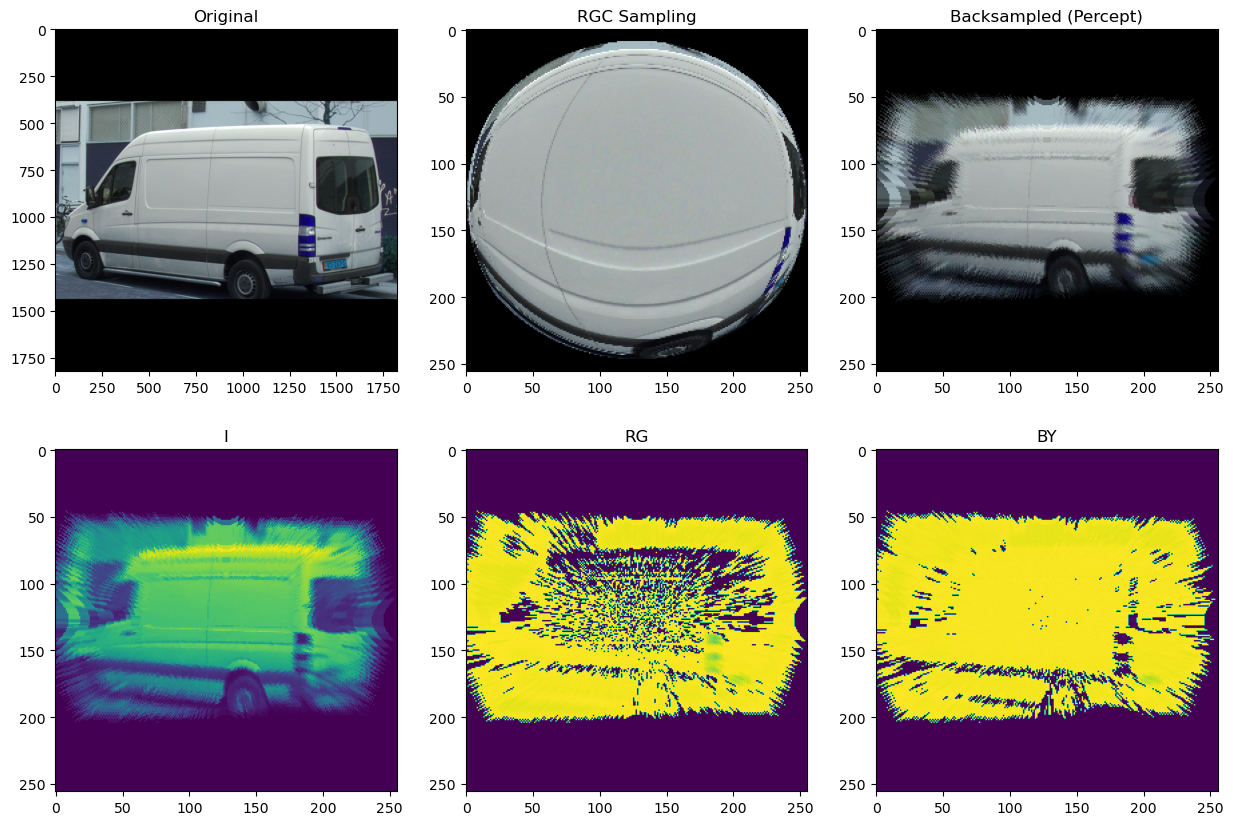

In [14]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax[0, 0].imshow(im)
ax[0, 1].imshow(im3)
ax[0, 2].imshow(backsampled_image)

ax[1, 0].imshow(coc_backsampled_image[:,:,0])
ax[1, 1].imshow(coc_backsampled_image[:,:,1])
ax[1, 2].imshow(coc_backsampled_image[:,:,2])

ax[0, 0].set_title('Original')
ax[0, 1].set_title('RGC Sampling')
ax[0, 2].set_title('Backsampled (Percept)')
ax[1, 0].set_title('I')
ax[1, 1].set_title('RG')
ax[1, 2].set_title('BY')

plt.show()

In [3]:
sample = Image.open('/home/nmuller/projects/data/oads/oads_arw/tiff/0000018494729a82.tiff')

In [4]:
sample.size

(5496, 3672)

In [10]:
5496 // 6

916

In [22]:
ToRGC = ToRetinalGanglionCellSampling(out_size=5496)

In [16]:
rgc = ToRGC(sample)

In [23]:
rgc_large = ToRGC(sample)

KeyboardInterrupt: 

In [ ]:
rgc_large_downsampled = rgc_large[::20, ::20, :]

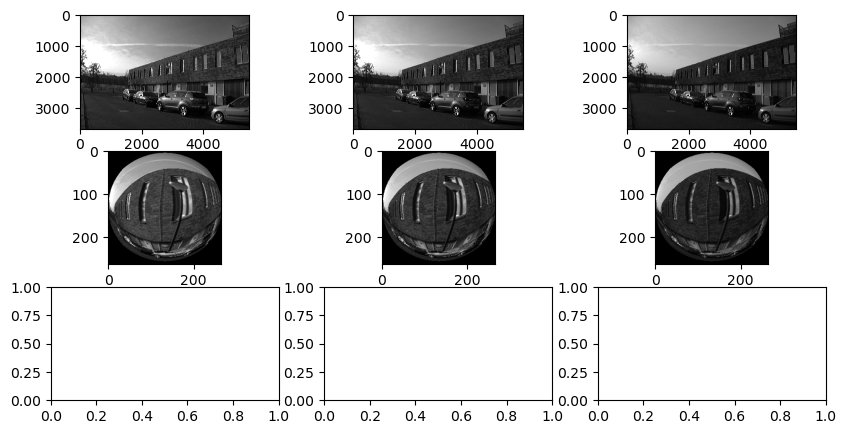

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(10,5))
ax[0, 0].imshow(np.array(sample)[:,:,0], cmap='gray')
ax[0, 1].imshow(np.array(sample)[:,:,1], cmap='gray')
ax[0, 2].imshow(np.array(sample)[:,:,2], cmap='gray')
ax[0,0].set_title('Orignal')
ax[1, 0].imshow(rgc[:,:,0], cmap='gray')
ax[1, 1].imshow(rgc[:,:,1], cmap='gray')
ax[1, 2].imshow(rgc[:,:,2], cmap='gray')
ax[1, 0].set_title('Sampling 265x265 on full orginal')
ax[2, 0].imshow(rgc_large[:,:,0], cmap='gray')
ax[2, 1].imshow(rgc_large[:,:,1], cmap='gray')
ax[2, 2].imshow(rgc_large[:,:,2], cmap='gray')
ax[2, 0].set_title('Sampling full on full orginal')
ax[3, 0].imshow(rgc_large_downsampled[:,:,0], cmap='gray')
ax[3, 1].imshow(rgc_large_downsampled[:,:,1], cmap='gray')
ax[3, 2].imshow(rgc_large_downsampled[:,:,2], cmap='gray')
ax[3, 0].set_title('Sampling full on full orginal')

plt.show()

# LGN Filtering

In [3]:
from oads_access.oads_access import OADS_Access
from oads_access.utils import loadmat
from pytorch_utils.pytorch_utils import ToRGBEdges
import os

In [4]:
oads = OADS_Access(basedir='/home/nmuller/projects/data/oads/', n_processes=8)

# COC Dataset mean/std

In [76]:
def mean_std_coc(tup):
    COC = ToOpponentChannel()

    coc_img = COC(tup[0])
    mean = np.mean(coc_img, axis=(0, 1))
    std = np.std(coc_img, axis=(0, 1))

    return mean, std

In [77]:
res = oads.apply_per_crop(custom_function=mean_std_coc)

100%|██████████| 18/18 [24:43<00:00, 82.44s/it] 


In [86]:
means = []
stds = []
for d, l in res.items():
    for image_name, (m, s) in l.items():
        means.append(m)
        stds.append(s)

In [99]:
print(np.mean(means, axis=0) / 255)
print(np.std(stds, axis=0) / 255)

[0.30080804 0.02202087 0.01321364]
[0.06359817 0.01878176 0.0180428 ]


# RGC Sampling

In [56]:
image = '/home/nmuller/projects/data/oads/oads_arw/crops/ML/Van/0a3cfa7a2780c0f0_1.tiff'
image = Image.open(image)

In [8]:
threshold_lgn_path = f'{os.path.expanduser("~")}/projects/lgnpy/ThresholdLGN.mat'
default_config_path = f'{os.path.expanduser("~")}/projects/lgnpy/lgnpy/CEandSC/default_config.yml'
threshold_lgn = loadmat(threshold_lgn_path)['ThresholdLGN']

Could not load mat file with mat73 - trying to load with scipy.io.loadmat!


In [63]:
edges = ToRGBEdges(threshold_lgn=threshold_lgn, default_config_path=default_config_path)(image)

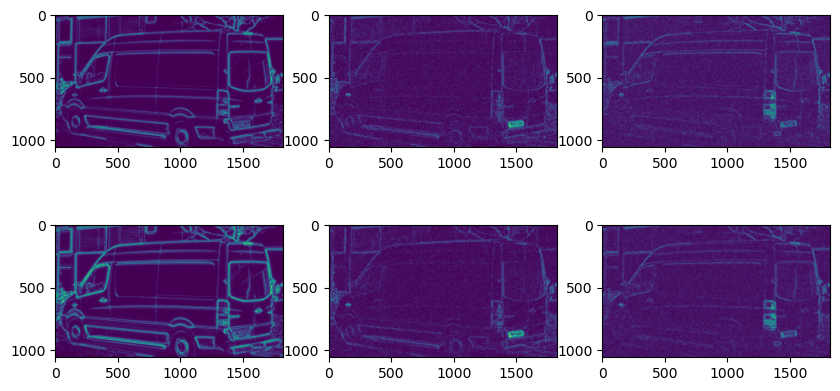

In [70]:
fig, ax = plt.subplots(2,3, figsize=(10,5))

ax[0, 0].imshow(edges[:,:,0])
ax[0, 1].imshow(edges[:,:,1])
ax[0, 2].imshow(edges[:,:,2])
ax[1, 0].imshow(edges[:,:,3])
ax[1, 1].imshow(edges[:,:,4])
ax[1, 2].imshow(edges[:,:,5])

plt.show()

In [5]:
image_ids = []
for image_name, info in oads.image_names.items():
    # if len(dataset_names) > 0 and info['dataset_name'] not in dataset_names:
    #     continue
    for index, _ in oads.image_names[image_name]['object_labels'].items():
            image_ids.append((image_name, index))

image_ids = list(set(image_ids))

In [13]:
ToEdges = ToRGBEdges(threshold_lgn=threshold_lgn, default_config_path=default_config_path)

In [28]:
import tqdm
import numpy as np
import os

In [27]:
crop_dir = '/home/nmuller/projects/data/oads/oads_arw/crops/ML_edges'

In [30]:
for image_id in tqdm.tqdm(image_ids):
    image_name, index = image_id
    (img, obj) = oads.load_crop_from_image(image_name=image_name, index=index)
    class_name = obj['classTitle']
    edges = ToEdges(img)

    os.makedirs(os.path.join(crop_dir, class_name), exist_ok=True)

    np.save(os.path.join(crop_dir, class_name, f'{image_name}_{index}.npy'), arr=edges, allow_pickle=True)

  0%|          | 38/86428 [01:03<40:17:44,  1.68s/it] 


KeyboardInterrupt: 